# 2018-05-14 - Test feedforward, unsync, lateral avec 16 thetas 
## Feedforward

Images en 64x64 parce que le 32x32 est trop aliasé pour que le network puisse apprendre :

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=16, shuffle=True,
                                             num_workers=1)

test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=16,shuffle=False,
                                             num_workers=1)

On affiche des images du set importé pour vérifier que tout a bien marché :

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# pour montrer une image
def imshow(img):
    img = img / 2 + 0.5    #de-normaliser
    npimg = img.numpy()    #convertir en array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# on loop sur un batch
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))


Réseau à trois couches :

In [ ]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(64*64,1000)
            self.fc2 = nn.Linear(1000, 200)
            self.fc3 = nn.Linear(200, 16)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(input=x)
model = Net()
print(model)

Et l'optimiseur, toujours en SGD mais avec un learning rate 10 fois plus grand. Avec NLLL comme critère, on a rajouté une couche de softmax en sortie pour obtenir des log-proba.

In [ ]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

On entraine :

In [ ]:
import time
start_time = time.time()
print("Started training")

epochs = 50
print_interval = 50 #prints every p_i*4
tempo = []
acc = []

for epoch in range(epochs):  # nbr epochs
    for batch_idx, (data, target) in enumerate(train_loader): #nbr batch,in,out
        data, target = Variable(data), Variable(target)
        
        #On resize pour la sortie
        data = data.view(-1, 64*64)

        #init l'entrainement
        optimizer.zero_grad()
        net_out = model(data)

        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()

        #afficher la progression
        if batch_idx % print_interval == 0:
            #le print statement le plus illisible du monde
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))
    tempo.append(epoch)
    acc.append(loss.data[0])
    
print("Finished training in  %.3f seconds " % (time.time() - start_time))

Et maintenant on teste :

In [ ]:
test_loss = 0
correct = 0

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    
    #rescale
    data = data.view(-1, 64 * 64)
    net_out = model(data)
    
    #somme des pertes du batch
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1] #prediction
    correct += pred.eq(target.data).sum() #output du réseau

test_loss /= len(test_loader.dataset) #loss = loss/length set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

On sauvegarde le modèle :

In [ ]:
torch.save(model.state_dict(), "MODEL_trainEASY_pytorchMC16")

In [ ]:
#joli plot du loss en fonction de l'epoch
import matplotlib.pyplot as plt
plt.plot(tempo, acc)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss variation - Easy training')
plt.savefig('Loss_easytraining.png')
plt.show()

## Unsync learning
Layer par layer donc, comme lors de l'ajout du L2 sur CHAMP :

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=16, shuffle=True,
                                             num_workers=1)

test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=16,shuffle=False,
                                             num_workers=1)

Le même network qu'en forward classique :

In [2]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(64*64,1000)
            self.fc2 = nn.Linear(1000, 200)
            self.fc3 = nn.Linear(200, 16)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(input=x)
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=4096, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=16, bias=True)
)


On modifie les flags du réseau pour n'entrainer qu'un seul layer :

In [3]:
#freeze layers after and including freezing_layer+1 (layers start at 0)
def freeze_layers(freezing_layer, nn_model = model) :
    for count,child in enumerate(model.children()) :
        if count < freezing_layer+1 : #to freeze at iteration 1
            print("Layer no. %s -- %s -- NOT FROZEN"% (count,child))
            for param in child.parameters():
                param.requires_grad = True
        else :
            print("Layer no. %s -- %s -- FROZEN"%(count, child))
            for param in child.parameters():
                param.requires_grad = False

#freeze all the layers except the unfrozen one
def freeze_all_layers(unfrozen_layer, nn_model = model) :
    for count,child in enumerate(model.children()) :
        if count == unfrozen_layer :
            print("Layer no. %s -- %s -- NOT FROZEN"% (count,child))
            for param in child.parameters():
                param.requires_grad = True
        else :
            print("Layer no. %s -- %s -- FROZEN"%(count, child))
            for param in child.parameters():
                param.requires_grad = False

#unfreeze every layers
def layers_microwave(nn_model = model) :
    for count,child in enumerate(model.children()) :
        for param in child.parameters():
            param.requires_grad = True

In [4]:
import torch.optim as optim
import time

#unfreeze before starting
layers_microwave(model)

criterion = nn.NLLLoss() #loss criterion
epochs = 20 #nbr of epochs per layer
model_size = 3 #nbr of layers

print_interval = 50 #prints every p_i*4
tempo = []
acc = []

start_time = time.time()
print("Started training")


#################
#Loop over layers
################
for layer in range(model_size) :
    freeze_all_layers(layer, model)
    optimizer = optim.SGD(filter(lambda p : p.requires_grad, model.parameters()), #optimize only on requires_grad layers
                      lr=0.01, momentum=0.9)
    
    #################
    #Loop over epochs
    ################
    for epoch in range(epochs):  # nbr epochs
        for batch_idx, (data, target) in enumerate(train_loader): #nbr batch,in,out
            data, target = Variable(data), Variable(target)

            #On resize pour la sortie
            data = data.view(-1, 64*64)

            #init l'entrainement
            optimizer.zero_grad()
            net_out = model(data)

            loss = criterion(net_out, target)
            loss.backward()
            optimizer.step()

            #afficher la progression
            if batch_idx % print_interval == 0:
                #le print statement le plus illisible du monde
                print('Epoch: {} [{}/{} ({:.0f}%)]\t\tLoss: {:.6f}'.format(
                        epoch+1, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.data[0]))
        tempo.append(epoch)
        acc.append(loss.data[0])



print("Finished training in  %.3f seconds " % (time.time() - start_time))

Started training
Layer no. 0 -- Linear(in_features=4096, out_features=1000, bias=True) -- NOT FROZEN
Layer no. 1 -- Linear(in_features=1000, out_features=200, bias=True) -- FROZEN
Layer no. 2 -- Linear(in_features=200, out_features=16, bias=True) -- FROZEN


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Epoch: 1 [0/1920 (0%)]		Loss: 2.782913
Epoch: 1 [800/1920 (42%)]		Loss: 2.777709
Epoch: 1 [1600/1920 (83%)]		Loss: 2.783829
Epoch: 2 [0/1920 (0%)]		Loss: 2.756960
Epoch: 2 [800/1920 (42%)]		Loss: 2.768983
Epoch: 2 [1600/1920 (83%)]		Loss: 2.773184
Epoch: 3 [0/1920 (0%)]		Loss: 2.749019
Epoch: 3 [800/1920 (42%)]		Loss: 2.735907
Epoch: 3 [1600/1920 (83%)]		Loss: 2.749079
Epoch: 4 [0/1920 (0%)]		Loss: 2.732347
Epoch: 4 [800/1920 (42%)]		Loss: 2.725827
Epoch: 4 [1600/1920 (83%)]		Loss: 2.762542
Epoch: 5 [0/1920 (0%)]		Loss: 2.721490
Epoch: 5 [800/1920 (42%)]		Loss: 2.716129
Epoch: 5 [1600/1920 (83%)]		Loss: 2.726128
Epoch: 6 [0/1920 (0%)]		Loss: 2.728941
Epoch: 6 [800/1920 (42%)]		Loss: 2.729384
Epoch: 6 [1600/1920 (83%)]		Loss: 2.706786
Epoch: 7 [0/1920 (0%)]		Loss: 2.704934
Epoch: 7 [800/1920 (42%)]		Loss: 2.703886
Epoch: 7 [1600/1920 (83%)]		Loss: 2.688040
Epoch: 8 [0/1920 (0%)]		Loss: 2.698377
Epoch: 8 [800/1920 (42%)]		Loss: 2.682473
Epoch: 8 [1600/1920 (83%)]		Loss: 2.686484
Epoch: 9

In [5]:
test_loss = 0
correct = 0

for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    
    #rescale
    data = data.view(-1, 64 * 64)
    net_out = model(data)
    
    #somme des pertes du batch
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1] #prediction
    correct += pred.eq(target.data).sum() #output du réseau

test_loss /= len(test_loader.dataset) #loss = loss/length set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()



Test set: Average loss: 0.2125, Accuracy: 73/192 (38%)



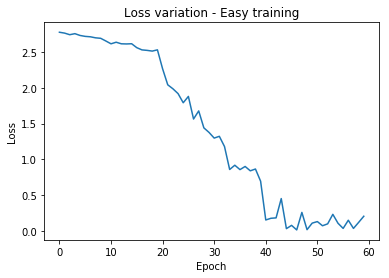

In [16]:
#joli plot du loss en fonction de l'epoch
import matplotlib.pyplot as plt
plt.plot(tempo2, acc)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss variation - Easy training')
plt.savefig('mc16easy_unsync.png')
plt.show()


## Lateral 

In [7]:
import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=16, shuffle=True,
                                             num_workers=1)

test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=16,shuffle=False,
                                             num_workers=1)

In [10]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            #forward
            self.fc1 = nn.Linear(64*64,1000)
            self.rec = nn.RNN(1000, hidden_size = 200,
                             num_layers=2, nonlinearity='relu',
                             batch_first = True)

        

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = self.rec(x)
            return F.log_softmax(input=x)
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=4096, out_features=1000, bias=True)
  (rec): RNN(1000, 200, num_layers=2, batch_first=True)
)


In [11]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

import time
start_time = time.time()
print("Started training")

epochs = 50
print_interval = 50 #prints every p_i*4
tempo = []
acc = []

for epoch in range(epochs):  # nbr epochs
    for batch_idx, (data, target) in enumerate(train_loader): #nbr batch,in,out
        data, target = Variable(data), Variable(target)
        
        #On resize pour la sortie
        data = data.view(-1, 64*64)

        #init l'entrainement
        optimizer.zero_grad()
        net_out = model(data)

        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()

        #afficher la progression
        if batch_idx % print_interval == 0:
            #le print statement le plus illisible du monde
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))
    tempo.append(epoch)
    acc.append(loss.data[0])
    
print("Finished training in  %.3f seconds " % (time.time() - start_time))

Started training


RuntimeError: input must have 3 dimensions, got 2